# EDA



- jot-down the steps you took, 
- the patterns you were able to identify 
- key ideas/assumptions you took when designing the model(s) underlying your prediction engine! 


### In this problem, we will be exploring the following question: given a sequence of transactions, can we predict when the next transaction in that sequence will occur? 

we can, and this is something that our backend AI systems do quite extensively. Our goal is to get as "good" as we can at the transaction sequence forecasting problem as we can
within a limited amount of time. Having a fundamental understanding of how these transaction sequences behave will be key to producing a model or algorithm that excels at the
forecasting task


### Formalized objective: design and implement a system which, for any given transaction series S, consisting of n different chronologically-ordered transactions s_1, s_2, s_3 ... , s_n, predicts the posted_at date and amount_cents of the next element in the series (s_n+1)

In [ ]:
# observation
# most series have no weekend transactions


# more time
# - better validation, leave one out 
# - more feature engineering
# - more time on predicting amount
# - use account_id 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from datetime import date, timedelta
from pandas.tseries.offsets import BDay
from scipy import stats
from tqdm import tqdm
%matplotlib inline

In [2]:
dat = pd.read_csv('data/train_val.csv', names=['account_id', 'series_id', 'posted_at', 'amount_cents'], 
                  parse_dates=['posted_at'])
print('rows: {}, columns: {}'.format(*dat.shape))
print('unique series_id: {}'.format(dat.series_id.nunique()))
# round to day
dat = dat.assign(posted_at=dat.posted_at.dt.floor('D'))
dat.head()

rows: 374508, columns: 4
unique series_id: 51534


,account_id,series_id,posted_at,amount_cents
0,54ad727ddc76040900d55051,54ad727ddc76040900d55051|82267c03919ef18dabc33...,2017-09-27,2754
1,54b80cb0cb084b0c00294f2a,54b80cb0cb084b0c00294f2a|6ce908fc9895fdfc035e4...,2018-06-08,538
2,54bde3073deefe0c00a01401,54bde3073deefe0c00a01401|46e37148a68739387c48b...,2017-11-28,1614
3,54c6ea8213078c0c001cec71,54c6ea8213078c0c001cec71|044a408e374c8a102b709...,2018-04-02,22105
4,54e643cd95962f0c004cde71,54e643cd95962f0c004cde71|ee74f9800708efd6b39c3...,2018-05-29,7803


In [3]:
# Create pivot table for dates 
def create_pivot(column, fillna=False):
    time_dat = dat.copy()
    time_dat.set_index(['posted_at'], inplace=True)
    idx = pd.date_range(dat.posted_at.min(), dat.posted_at.max())
    time_dat.index = pd.DatetimeIndex(time_dat.index)
    time_dat.reset_index(inplace=True)
    time_dat = time_dat.pivot_table(values='amount_cents', index=column, columns='posted_at')
    if fillna: time_dat = time_dat.fillna(0)
    return time_dat

def create_pivot_BS(column, fillna=False, use_bs_days_only=False):
    time_dat = dat.copy()
    time_dat.set_index(['posted_at'], inplace=True)
    idx = pd.date_range(dat.posted_at.min(), dat.posted_at.max(), freq=BDay())
    time_dat.index = pd.DatetimeIndex(time_dat.index)
    time_dat.reset_index(inplace=True)
    time_dat = time_dat.pivot_table(values='amount_cents', index=column, columns='posted_at')
    if fillna: time_dat = time_dat.fillna(0)
    if use_bs_days_only: time_dat = time_dat[idx]
    return time_dat
# LOOK INTO STRIPPING HOURS, etc...

# # plot store time series 
# def plot_individual(id_, df, date_range=None):
#     sample = df.loc[id_]
#     if date_range:
#         # example '2017-09-16', '2017-09-20'
#         sample = sample.loc[pd.date_range(date_range[0], date_range[1])]
#     sample.plot(kind='bar', figsize=(20, 5))
# #     plt.xticks(np.where(sample != 0)[0])
# #     print(list(sample != 0))
# #     plt.xticks([i for i, v in zip(list(range(len(sample.index))), sample) if v > 0])
#     plt.title('Transactions for {}'.format(id_))
#     plt.ylabel('Amount in Cents')
#     plt.tight_layout()
    
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn_pandas import DataFrameMapper
warnings.filterwarnings('ignore')
import re

def transform_date(df, field_name, drop=True):
    field = df[field_name]
    if not np.issubdtype(field, np.datetime64):
        df[field_name] = field = pd.to_datetime(field, infer_datetime_format=True)
    target_pre = re.sub('[Dd]ate$', '', field_name)
#     for i in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear'):
    for i in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[target_pre + i] = getattr(field.dt, i.lower())
    df[target_pre + 'Elapsed'] = field.astype(np.int64) // 10**9
    if drop:
        df.drop(field_name, axis=1, inplace=True)


# from a time (dt) go back (minus) day to get data from days a certain number of days (periods)
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]
    
def plot_individual(id_, df, date_range=None):
    fig, ax = plt.subplots()
    sample = df.loc[id_]
    if date_range:
        # example '2017-09-16', '2017-09-20'
        sample = sample.loc[pd.date_range(date_range[0], date_range[1])]
    sample.plot(kind='bar', figsize=(20, 5), ax=ax)
    for label, value in zip(ax.xaxis.get_ticklabels(), sample):
        if value == 0 or np.isnan(value):
            label.set_visible(False)
    plt.title('Transactions for {}'.format(id_))
    plt.ylabel('Amount in Cents')
    plt.tight_layout()

In [4]:
# Metrics 


# Spot-on timestamp prediction rate: given a total of k series, for how many series can your system predict the next transaction in that series's posted_at date? This would
# correspond to the scoring formula n_correct/k, where n_correct is defined as the number of series s_1, s_2, s_3 ... , s_n for which your system was able to
# precisely predict the posted_at date of  s_n+1

def spot_on_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# In-range timestamp prediction rate: same as spot-on prediction rate, but with a looser acceptance criteria where n_correct is defined as the number of series s_1, s_2,
# s_3 ... , s_n for which your system was able to predict the posted_at date of  s_n+1 within the range of +/- 1 business day. For this assignments purpose, you can
# assume that every weekday is a business day.

def in_range_accuracy(y_trues, y_preds, range_=1):
    N = len(y_trues)
    n_correct = 0
    for i in tqdm(range(len(y_trues))): 
        y_true = y_trues[i]
        y_pred = y_preds[i]
        true = pd.Timestamp(y_true)
        before_date = true - BDay()
        after_date = true + BDay()
        date_range = pd.date_range(before_date, after_date, freq=BDay())
        if (y_pred in date_range) or (y_pred == y_true): # needed for weekends 
            n_correct += 1
    return n_correct / N


from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    np.sqrt(mean_squared_error(y_true, y_pred))

In [5]:
accounts = create_pivot_BS('account_id')
accounts.head()

posted_at,2017-09-14 00:00:00,2017-09-15 00:00:00,2017-09-16 00:00:00,2017-09-17 00:00:00,2017-09-18 00:00:00,2017-09-19 00:00:00,2017-09-20 00:00:00,2017-09-21 00:00:00,2017-09-22 00:00:00,2017-09-23 00:00:00,...,2018-06-11 00:00:00,2018-06-12 00:00:00,2018-06-13 00:00:00,2018-06-14 00:00:00,2018-06-15 00:00:00,2018-06-16 00:00:00,2018-06-17 00:00:00,2018-06-18 00:00:00,2018-06-19 00:00:00,2018-06-20 00:00:00
account_id,,,,,,,,,,,,,,,,,,,,,
53a85331e431960200466a39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53a85378e431960200469d42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,200.0,200.0,200.0,NaN,200.0,NaN,NaN,200.0,100.0,NaN
53a85392e43196020046b36b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53a853aee43196020046c978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53cd28ca4f66f20b0022bb4b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# series = create_pivot('series_id')
# series.head()
series = create_pivot_BS('series_id')
series.head()

posted_at,2017-09-14 00:00:00,2017-09-15 00:00:00,2017-09-16 00:00:00,2017-09-17 00:00:00,2017-09-18 00:00:00,2017-09-19 00:00:00,2017-09-20 00:00:00,2017-09-21 00:00:00,2017-09-22 00:00:00,2017-09-23 00:00:00,...,2018-06-11 00:00:00,2018-06-12 00:00:00,2018-06-13 00:00:00,2018-06-14 00:00:00,2018-06-15 00:00:00,2018-06-16 00:00:00,2018-06-17 00:00:00,2018-06-18 00:00:00,2018-06-19 00:00:00,2018-06-20 00:00:00
series_id,,,,,,,,,,,,,,,,,,,,,
53a85331e431960200466a39|140fae5cfea3485ab5c6d7f7266677ba|0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53a85378e431960200469d42|76f7222aa18d6b39a7ebdd5168b1ffd4|0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53a85378e431960200469d42|ff242a09ec5b7f16a4941334c39783ea|0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,200.0,200.0,200.0,NaN,200.0,NaN,NaN,200.0,100.0,NaN
53a85392e43196020046b36b|76d3583b46575283f21d8cd598659d4c|0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53a853aee43196020046c978|9bd3a9269b8f1d37371e5b0205bb67df|0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


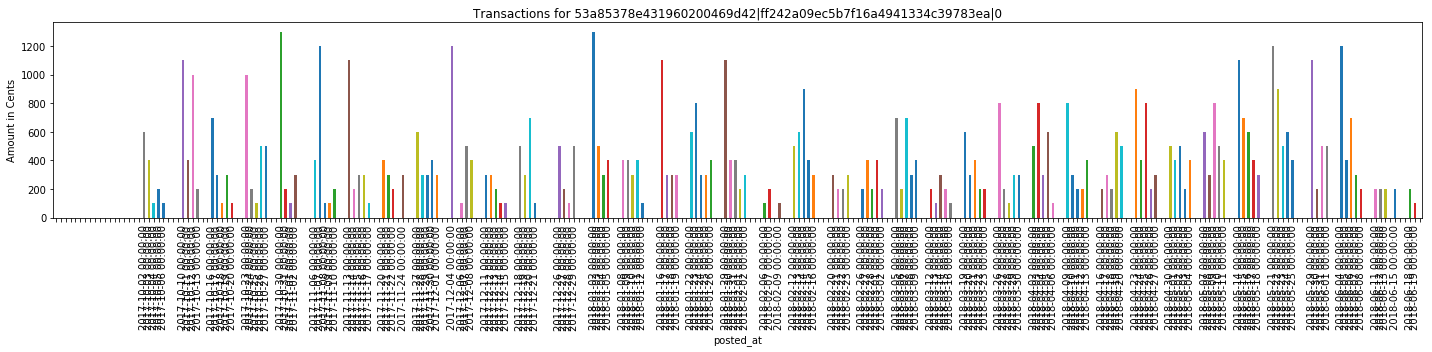

In [7]:
plot_individual('53a85378e431960200469d42|ff242a09ec5b7f16a4941334c39783ea|0', series)
# plot_individual_account('54b80cb0cb084b0c00294f2a', pivot, date_range=('2017-09-16', '2017-11-20'))

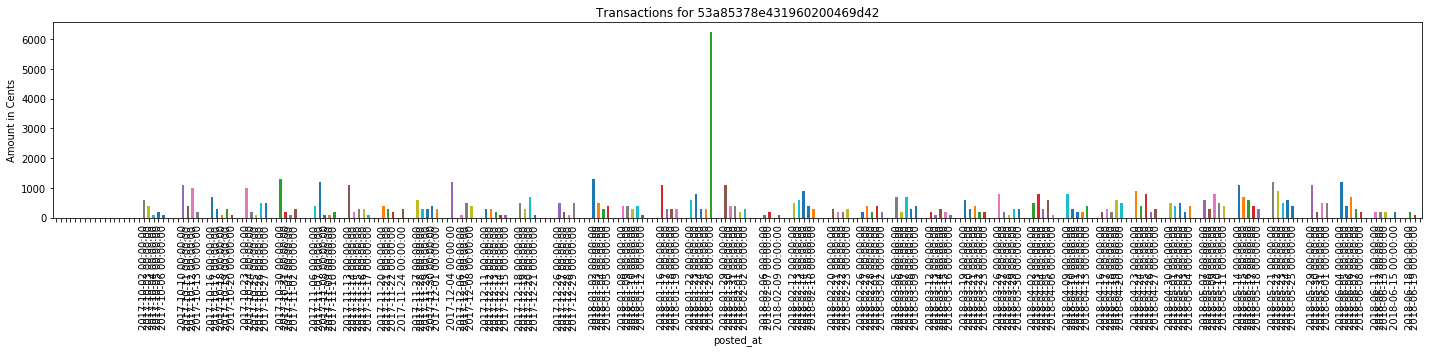

In [8]:
plot_individual('53a85378e431960200469d42', accounts)

In [9]:
# day of week 
from collections import Counter
Counter(dat.posted_at.dt.dayofweek.values)

Counter({0: 99450, 1: 74931, 2: 59872, 3: 60078, 4: 73395, 5: 3655, 6: 3127})

In [10]:
# mapping of series_id : number of total transactions 
num_transactions_dict = {}
counter = Counter()
for v in series.index:
    sample = series.loc[v]
    counts = len(sample[sample.notnull()])
    counter[counts] += 1
    num_transactions_dict[v] = counts

In [11]:
# mostly low number of transactions per series 
counter.most_common(10)

[(1, 13282),
 (2, 7671),
 (3, 5207),
 (4, 3963),
 (5, 3098),
 (8, 2699),
 (6, 2479),
 (7, 2343),
 (9, 1340),
 (10, 915)]

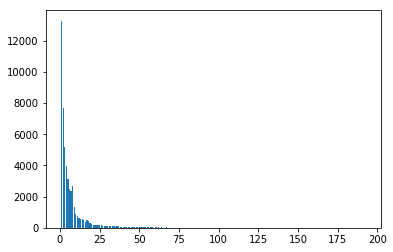

In [12]:
plt.bar(counter.keys(), counter.values());

In [13]:
num_transactions_dict

{'53a85331e431960200466a39|140fae5cfea3485ab5c6d7f7266677ba|0': 3,
 '53a85378e431960200469d42|76f7222aa18d6b39a7ebdd5168b1ffd4|0': 1,
 '53a85378e431960200469d42|ff242a09ec5b7f16a4941334c39783ea|0': 174,
 '53a85392e43196020046b36b|76d3583b46575283f21d8cd598659d4c|0': 1,
 '53a853aee43196020046c978|9bd3a9269b8f1d37371e5b0205bb67df|0': 3,
 '53cd28ca4f66f20b0022bb4b|7dac986d12cfe32d95fc0c5c2a33bd5d|0': 2,
 '53ce0877e0de550b0008841e|a37c17d87ba95d13ce6dae872e545478|0': 6,
 '53ce61957d637d0b006156dd|aa3b3b6983477781e67f5e8a53e7a0d2|0': 15,
 '53cfb9b70c59fd0b00cf5143|9c184805bc43c862209d99a72a0acbb0|1': 4,
 '53d022557dfe120b004b959c|74f889c4617bef9c54d72021fdf968d2|1': 27,
 '53d81edf009db60b002cb3b0|19498677be24648a6879699d65fc8c3d|0': 2,
 '53d8d74e1897030b0094c681|dbdae0245770647f7b453b450ae634be|0': 1,
 '53ea489e9f7fbf0b002774ec|e9f827b3ee378184f7a2a584d74db310|0': 8,
 '53f6361b9cad9a0b0067d648|81b7f2db125703b945e24c2b08b13545|0': 2,
 '53f6361b9cad9a0b0067d648|df8e5c25aaf18802c2c3a9bfab15aa1

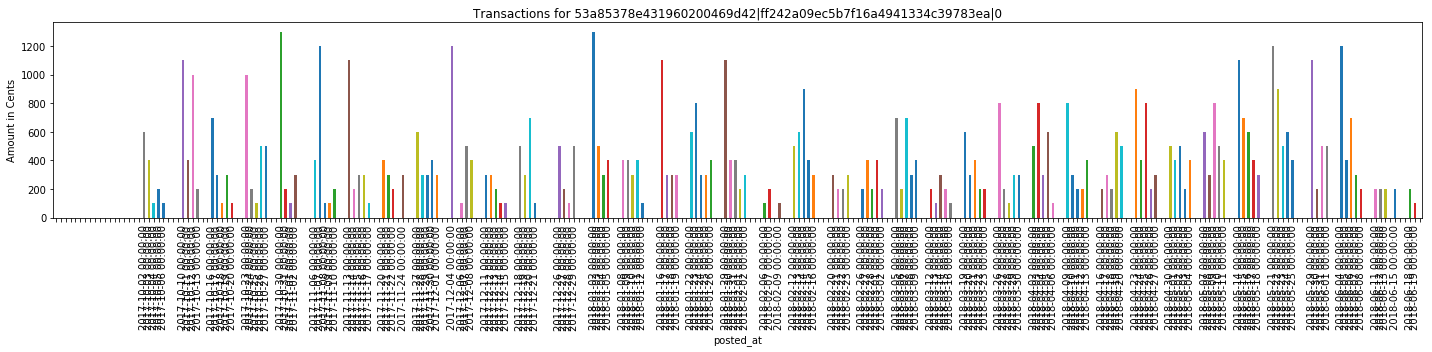

In [15]:
plot_individual('53a85378e431960200469d42|ff242a09ec5b7f16a4941334c39783ea|0', series)

In [19]:
# exponential smoothing for amount_cents prediction  
def exponential_smoothing(panda_series, alpha_value):
    ouput=sum([alpha_value * (1 - alpha_value) ** i * x for i, x in enumerate(panda_series['amount_cents'])])
    return ouput

sample_series_id = '53a85378e431960200469d42|ff242a09ec5b7f16a4941334c39783ea|0'

panda_series = dat[dat.series_id == sample_series_id][['posted_at', 'amount_cents']].sort_values('posted_at')
smoothing_number = exponential_smoothing(panda_series, 0.6) # use a=0.6 or 0.5 your choice, which gives less rms error
smoothing_number

483.7558982985019

In [20]:
%%time
df = pd.DataFrame(index=series.index)
# series_id, then days till next purchase
all_data_sequences = []
for ser in series.index:
    day_sequence = []
    sample = series.loc[ser]
    non_null = pd.DataFrame(sample[sample.notnull()]).T
    for i in range(len(non_null.columns)-1):
        cur_date = non_null.columns[i]
        next_date = non_null.columns[i+1]
        # NEED TO ADD FINAL DATE
        diff = pd.Timedelta(next_date - cur_date).days
        day_sequence.append(diff)
    all_data_sequences.append(day_sequence)
df['day_sequence'] = all_data_sequences

CPU times: user 31 s, sys: 222 ms, total: 31.2 s
Wall time: 30.2 s


In [20]:
%%time
# df = pd.DataFrame(index=series.index)
# series_id, then days till next purchase
all_time_sequences = []
for ser in series.index:
    day_sequence = []
    sample = series.loc[ser]
    non_null = pd.DataFrame(sample[sample.notnull()]).T
    for i in range(len(non_null.columns)):
        cur_date = non_null.columns[i]
#         next_date = non_null.columns[i+1]
#         diff = pd.Timedelta(next_date - cur_date).days
        day_sequence.append(cur_date)
    all_time_sequences.append(day_sequence)
df['time_sequence'] = all_time_sequences

CPU times: user 25.2 s, sys: 128 ms, total: 25.3 s
Wall time: 24.7 s


# feature ideas
- mean difference in days
- std of difference in days
- exp moving average of diff
- bins
- count / mean days of weeks, months, etc... use transform_date
- prev 3 / 5 / 10 

In [25]:
def create_data_frame(df, value):
    new_df = df[df.day_sequence.map(lambda x: len(x) >= value)]
    new_df['y'] = new_df.day_sequence.map(lambda x: x[-1])
    new_df['X'] = new_df.day_sequence.map(lambda x: x[:-1])
    # mean 
    new_df['mean'] = new_df.X.map(lambda x: np.floor(np.mean(x)))
    # mode
    new_df['mode'] = new_df.X.map(lambda x: stats.mode(x)[0])
    
    new_df['y_time'] = new_df.time_sequence.map(lambda x: x[-1])
    new_df['y_time'] = new_df['y_time'].map(lambda x: pd.Timestamp(x))
    new_df['X_time_max'] = new_df.time_sequence.map(lambda x: x[:-1][-1])
    return new_df

df_more_than_one = df[df.day_sequence.map(lambda x: len(x) >= 1)]
df_more_than_two = df[df.day_sequence.map(lambda x: len(x) > 1)]

In [370]:
df_more_than_two.head()

,day_sequence,time_sequence
series_id,,
53a85331e431960200466a39|140fae5cfea3485ab5c6d7f7266677ba|0,"[37, 14]","[2018-03-05 00:00:00, 2018-04-11 00:00:00]"
53a85378e431960200469d42|ff242a09ec5b7f16a4941334c39783ea|0,"[1, 1, 1, 1, 4, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, ...","[2017-10-02 00:00:00, 2017-10-03 00:00:00, 201..."
53a853aee43196020046c978|9bd3a9269b8f1d37371e5b0205bb67df|0,"[7, 74]","[2017-12-01 00:00:00, 2017-12-08 00:00:00]"
53ce0877e0de550b0008841e|a37c17d87ba95d13ce6dae872e545478|0,"[29, 30, 32, 29, 29]","[2017-10-23 00:00:00, 2017-11-21 00:00:00, 201..."
53ce61957d637d0b006156dd|aa3b3b6983477781e67f5e8a53e7a0d2|0,"[13, 18, 11, 20, 10, 20, 12, 21, 9, 19, 29, 13...","[2017-10-10 00:00:00, 2017-10-23 00:00:00, 201..."


In [27]:
df_more_than_two['y'] = df_more_than_two.day_sequence.map(lambda x: x[-1])
df_more_than_two['X'] = df_more_than_two.day_sequence.map(lambda x: x[:-1])
df_more_than_two['mean'] = df_more_than_two.X.map(lambda x: np.floor(np.mean(x)))
df_more_than_two['mode'] = df_more_than_two.X.map(lambda x: stats.mode(x)[0][0])
df_more_than_two['y_time'] = df_more_than_two.time_sequence.map(lambda x: x[-1])
df_more_than_two['y_time'] = df_more_than_two['y_time'].map(lambda x: pd.Timestamp(x))
df_more_than_two['X_time_max'] = df_more_than_two.time_sequence.map(lambda x: x[:-1][-1])

In [34]:
def map_to_date(row):
    d = date(row['X_time_max'].year, row['X_time_max'].month, row['X_time_max'].day) 
    col = timedelta(row['mean'])
    return pd.Timestamp(d + col)
 
df_more_than_two['pred_date'] = df_more_than_two.apply(map_to_date, axis=1)

# need to not predict weekends 

### Ideas

bins

In how to model it, think of the different time periods between jobs as letters in an alphabet. In fact, you could assign each time period a letter, something like:
- A - 1 to 2 minutes
- B - 2 to 5 minutes
- C - 5 to 10 minutes

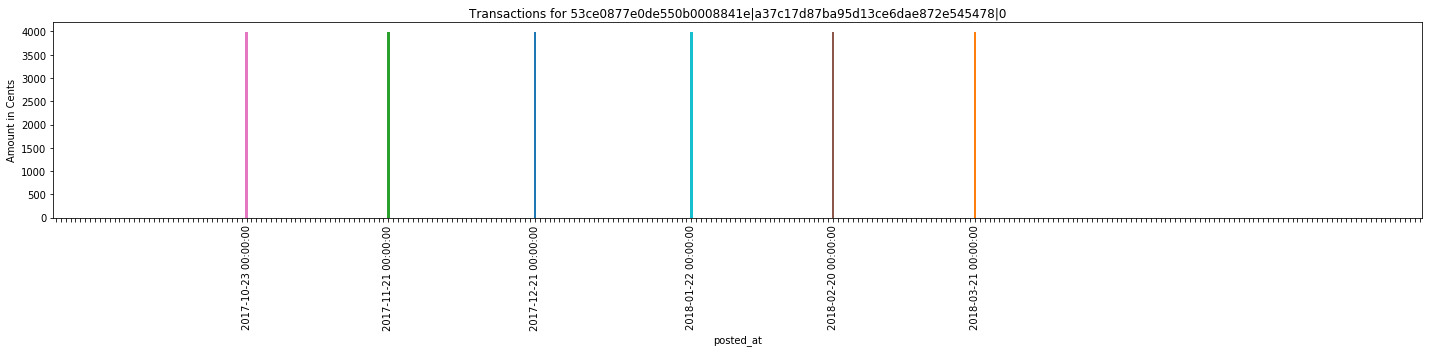

In [181]:
plot_individual('53ce0877e0de550b0008841e|a37c17d87ba95d13ce6dae872e545478|0', series)

In [309]:
# model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)  # Viterbi is set by default as the 'algorithm' optional parameter.
# model.fit(np.array(sample).reshape(-1, 1))
# state_sequence = model.predict(np.array(sample).reshape(-1, 1))
# prob_next_step = model.transmat_[state_sequence[-1], :]
# prob_next_step

In [330]:
from hmmlearn.hmm import MultinomialHMM, GaussianHMM
from sklearn.utils import check_random_state
preds = []
N = 0
n_state = 3
for i in tqdm(range(len(df_more_than_two))):
    N +=1
    sample = df_more_than_two.iloc[i].X
    if len(sample) > 5:
#         model = GaussianHMM(n_components=3, n_iter=1000).fit(np.array(sample).reshape(-1, 1))
        try:
            model = GaussianHMM(n_components=5, n_iter=1000)
    #         model.startprob_ = [10]
    #         if N == 7:
    #             print(sample)
    #         model.transmat_prior = [[0.5]]
#             model.transmat_ = np.random.random((n_state,n_state))
#             model.transmat_ = model.transmat_ / np.repeat(np.sum(model.transmat_, 1),n_state).reshape((n_state,n_state))
            model.fit(np.array(sample).reshape(-1, 1))
            states = model.predict(np.array(sample).reshape(-1, 1))
    #         the sum of the each transmat_ * the corresponding emissionprob_.
            transmat_cdf = np.cumsum(model.transmat_, axis=1)
            random_state = check_random_state(model.random_state)
            next_state = (transmat_cdf[states[-1]] > random_state.rand()).argmax()
    #         next_state = (transmat_cdf[states[-1]]).argmax()
        #     print(random_state, next_state)
    #         print(N, sample, model._generate_sample_from_state(next_state))
            pred = np.round(model._generate_sample_from_state(next_state)[0])
        except:
            model = GaussianHMM(n_components=1, n_iter=1000)
    #         model.startprob_ = [10]
    #         if N == 7:
    #             print(sample)
    #         model.transmat_prior = [[0.5]]
            model.transmat_ = np.random.random((n_state,n_state))
            model.transmat_ = model.transmat_ / np.repeat(np.sum(model.transmat_, 1),n_state).reshape((n_state,n_state))
            model.fit(np.array(sample).reshape(-1, 1))
            states = model.predict(np.array(sample).reshape(-1, 1))
    #         the sum of the each transmat_ * the corresponding emissionprob_.
            transmat_cdf = np.cumsum(model.transmat_, axis=1)
            random_state = check_random_state(model.random_state)
            next_state = (transmat_cdf[states[-1]] > random_state.rand()).argmax()
    #         next_state = (transmat_cdf[states[-1]]).argmax()
        #     print(random_state, next_state)
    #         print(N, sample, model._generate_sample_from_state(next_state))
            pred = np.round(model._generate_sample_from_state(next_state)[0])
    else:
        pred = stats.mode(sample)[0][0]
    preds.append(pred)
#         print(N, len(sample), sample)


100%|██████████| 30581/30581 [05:54<00:00, 86.36it/s]


In [327]:


def map_to_date(row):
    d = date(row['X_time_max'].year, row['X_time_max'].month, row['X_time_max'].day) 
    col = timedelta(row['HMM_pred'])
    return pd.Timestamp(d + col)
 
df_more_than_two['HMM_pred'] = preds
df_more_than_two['pred_date'] = df_more_than_two.apply(map_to_date, axis=1)


In [328]:
# df_more_than_two['']

print(spot_on_accuracy(df_more_than_two['y_time'].values, df_more_than_two['pred_date'].values))
print(in_range_accuracy(df_more_than_two['y_time'].values, df_more_than_two['pred_date'].values))

  0%|          | 97/30581 [00:00<00:31, 960.44it/s]

0.10087963114352048


100%|██████████| 30581/30581 [00:25<00:00, 1200.09it/s]

0.19907785880121645


In [308]:
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# label_encoder = LabelEncoder()
# ss = StandardScaler()

# sample = df_more_than_two.loc['53ce0877e0de550b0008841e|a37c17d87ba95d13ce6dae872e545478|0'].X
# sample = np.array(sample).reshape(-1, 1)
# # print(label_encoder.fit_transform(letters))
# # sample = np.stack((sample, label_encoder.fit_transform(letters)))
# print(sample)
# # X2 = [[np.mean(sample)]]
# X2 = [[100]]
# X = np.concatenate([sample, X2])
# lengths = [len(sample), len(X2)]

# # model = GaussianHMM(n_components=3, n_iter=1000).fit(np.array(sample).reshape(-1, 1))
# priors = [[0.01, 0.99]]
# model = GaussianHMM(n_components=3, n_iter=1000)
# model.startprob_ = np.array([0.99, 0.01])
# model.fit(X, lengths=lengths)
# states = model.predict(X, lengths=lengths)
# transmat_cdf = np.cumsum(model.transmat_, axis=1)
# random_state = check_random_state(model.random_state)
# # print(transmat_cdf[states[-1]])
# # print(random_state.rand())
# next_state = (transmat_cdf[states[-1]] > random_state.rand()).argmax()
# next_state = (transmat_cdf[states[-1]]).argmax()
# model._generate_sample_from_state(next_state)

In [266]:
X1 = [[0.5], [1.0], [-1.0], [0.42], [0.24]]
X2 = [[2.4], [4.2], [0.5], [-0.24]]
X = np.concatenate([X1, X2])
lengths = [len(X1), len(X2)]
lengths, X

([5, 4], array([[ 0.5 ],
        [ 1.  ],
        [-1.  ],
        [ 0.42],
        [ 0.24],
        [ 2.4 ],
        [ 4.2 ],
        [ 0.5 ],
        [-0.24]]))

In [230]:
bins = {}
bins['A'] = [1]
bins['B'] = [2]
bins['C'] = [3]
bins['D'] = list(range(4, 7))
bins['E'] = [7]
bins['F'] = list(range(8, 14))
bins['G'] = [14]
bins['H'] = list(range(15, 28))
bins['I'] = list(range(28, 32))
bins['J'] = list(range(32, 100))


# bins
letters = []

for x in df_more_than_two.loc['53ce0877e0de550b0008841e|a37c17d87ba95d13ce6dae872e545478|0'].X:
    for letter in 'ABCDEFGHIJ':
        if x in bins[letter]:
            letters.append(letter)
list(zip(letters, df_more_than_two.loc['53ce0877e0de550b0008841e|a37c17d87ba95d13ce6dae872e545478|0'].X))

[('I', 29), ('I', 30), ('J', 32), ('I', 29)]

In [86]:
sample = series.loc['53a853aee43196020046c978|9bd3a9269b8f1d37371e5b0205bb67df|0'].fillna(0)

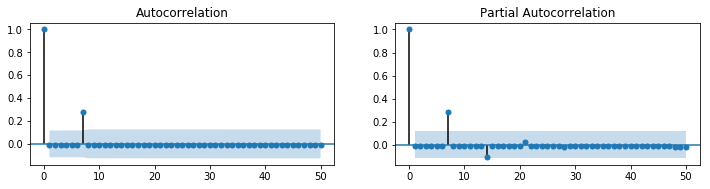

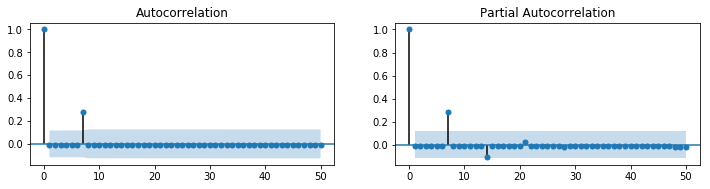

In [87]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA


plt.figure(figsize=(12, 12))
plt.subplot(423); plot_acf(sample, lags = 50, ax = plt.gca())
plt.subplot(424); plot_pacf(sample, lags = 50, ax = plt.gca())

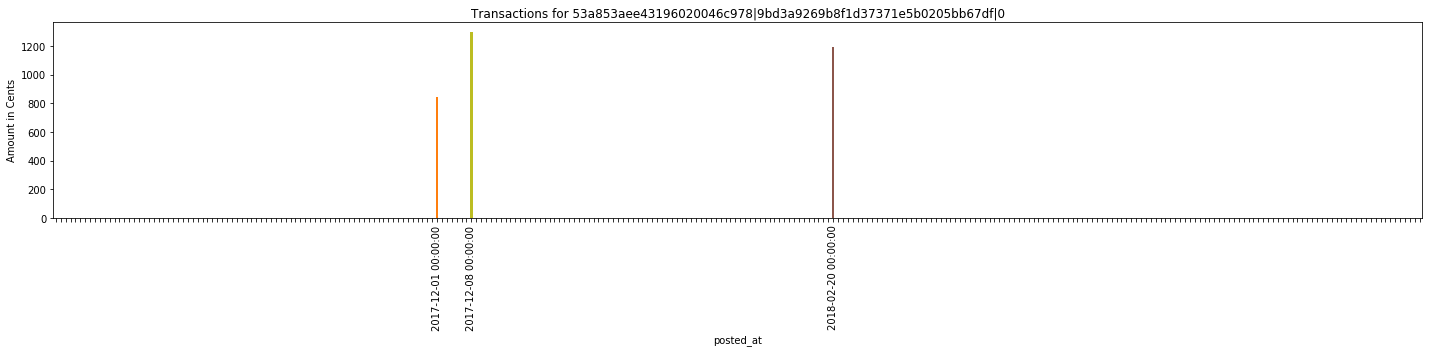

In [90]:
plot_individual('53a853aee43196020046c978|9bd3a9269b8f1d37371e5b0205bb67df|0', series)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


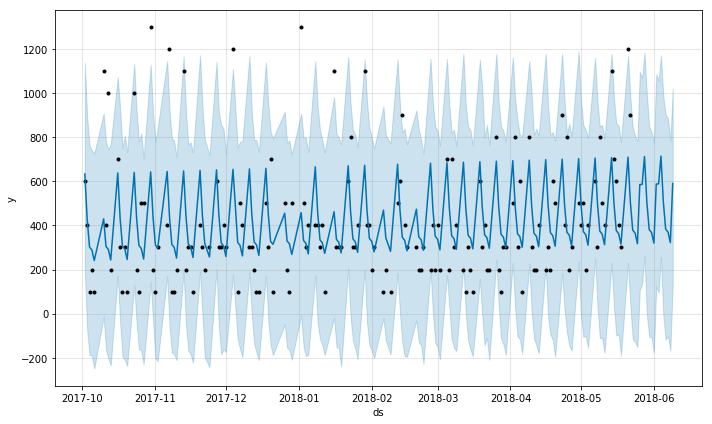

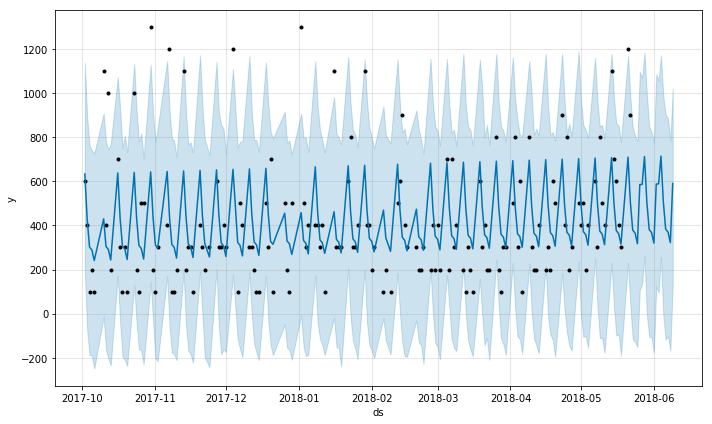

In [149]:
# prophet by Facebook
from fbprophet import Prophet

train_percent = 0.9

store = dat[dat.series_id == '53a85378e431960200469d42|ff242a09ec5b7f16a4941334c39783ea|0'][['posted_at', 'amount_cents']]
# store = df[df.Store == store_id][['Date', 'Sales']]
store = store.rename(columns={'posted_at': 'ds','amount_cents': 'y'}).sort_values('ds')

N = int(np.floor(train_percent * len(store)))  
prophet = Prophet(interval_width=0.95)
prophet.fit(store[:N]) 


# create future dataframe 
test_df = prophet.make_future_dataframe(len(store) - N)
# predict future dates 
forcast_store1_test_df = prophet.predict(test_df)

prophet.plot(forcast_store1_test_df)

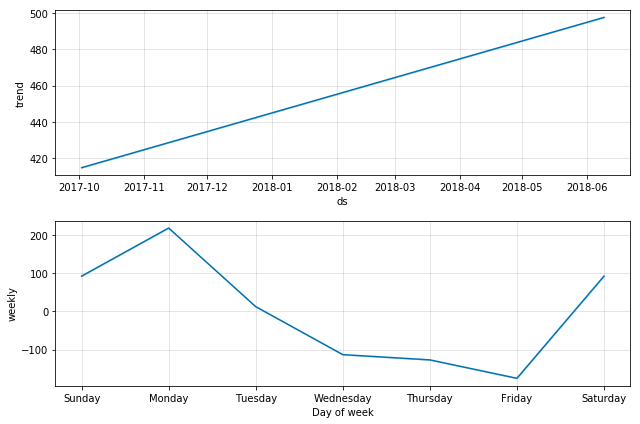

In [151]:
prophet.plot_components(forcast_store1_test_df);

In [329]:
# forcast_store1_test_df

In [109]:
# # from pyramid.arima import auto_arima

# # stepwise_model = auto_arima(sample, start_p=1, start_q=1,
# #                            max_p=3, max_q=3, m=12,
# #                            start_P=0, seasonal=True,
# #                            d=1, D=1, trace=True,
# #                            error_action='ignore',  
# #                            suppress_warnings=True, 
# #                            stepwise=True)

# # sample = series.loc[''].fillna(0)

# model = ARIMA(np.array(df_more_than_two.day_sequence[3], dtype=np.float32), order=(5,1,0))
# model_fit = model.fit()
# output = model_fit.forecast(steps=1)
# output[0]

In [33]:
# mode
print(spot_on_accuracy(df_more_than_two['y_time'].values, df_more_than_two['pred_date'].values))
print(in_range_accuracy(df_more_than_two['y_time'].values, df_more_than_two['pred_date'].values))

  0%|          | 143/30581 [00:00<00:21, 1422.08it/s]

0.1357378764592394


100%|██████████| 30581/30581 [00:21<00:00, 1420.83it/s]

0.24937052418168143


In [35]:
# mean 
print(spot_on_accuracy(df_more_than_two['y_time'].values, df_more_than_two['pred_date'].values))
print(in_range_accuracy(df_more_than_two['y_time'].values, df_more_than_two['pred_date'].values))

  0%|          | 135/30581 [00:00<00:22, 1343.66it/s]

0.086982113076747


100%|██████████| 30581/30581 [00:23<00:00, 1275.87it/s]

0.1885157450704686


In [174]:
pred_df = pd.DataFrame(df_more_than_two.index)
all_preds = []
for sample in df_more_than_two:
    id_ = df_more_than_two['']
    sequence = sample[1:]
    current_date = max_date.loc[id_].posted_at
    if sequence:
        # use # mode 
        mean_seq = np.mean(sequence)
        diff = date(current_date.year, current_date.month, current_date.day) + timedelta(round(mean_seq))

        all_preds.append(diff)
    else:
        all_preds.append('NaN')
pred_df['preds'] = all_preds  

In [140]:
max_date = dat.groupby('series_id')[['posted_at']].max()
max_date.head()

,posted_at
series_id,
53a85331e431960200466a39|140fae5cfea3485ab5c6d7f7266677ba|0,2018-04-25
53a85378e431960200469d42|76f7222aa18d6b39a7ebdd5168b1ffd4|0,2018-01-26
53a85378e431960200469d42|ff242a09ec5b7f16a4941334c39783ea|0,2018-06-19
53a85392e43196020046b36b|76d3583b46575283f21d8cd598659d4c|0,2017-12-05
53a853aee43196020046c978|9bd3a9269b8f1d37371e5b0205bb67df|0,2018-02-20


In [143]:
pred_df = pd.DataFrame(max_date.index)
all_preds = []
for sample in all_data_sequences:
    id_ = sample[0]
    sequence = sample[1:]
    current_date = max_date.loc[id_].posted_at
    if sequence:
        # use # mode 
        mean_seq = np.mean(sequence)
        diff = date(current_date.year, current_date.month, current_date.day) + timedelta(round(mean_seq))

        all_preds.append(diff)
    else:
        all_preds.append('NaN')
pred_df['preds'] = all_preds    

In [355]:
%%time 
all_amount_preds = []
from tqdm import tqdm

for sample_series_id in tqdm(dat.series_id.unique()):
# sample_series_id = '53a85331e431960200466a39|140fae5cfea3485ab5c6d7f7266677ba|0'
    panda_series = dat[dat.series_id == sample_series_id][['posted_at', 'amount_cents']].sort_values('posted_at')
    smoothing_number = exponential_smoothing(panda_series, 0.5) # use a=0.6 or 0.5 your choice, which gives less rms error
    all_amount_preds.append(smoothing_number)


100%|██████████| 51534/51534 [13:54<00:00, 61.77it/s]

CPU times: user 13min 57s, sys: 1.91 s, total: 13min 58s
Wall time: 13min 54s


In [144]:
pred_df

,series_id,preds
0,53a85331e431960200466a39|140fae5cfea3485ab5c6d...,2018-05-21
1,53a85378e431960200469d42|76f7222aa18d6b39a7ebd...,NaN
2,53a85378e431960200469d42|ff242a09ec5b7f16a4941...,2018-06-21
3,53a85392e43196020046b36b|76d3583b46575283f21d8...,NaN
4,53a853aee43196020046c978|9bd3a9269b8f1d37371e5...,2018-04-01
5,53cd28ca4f66f20b0022bb4b|7dac986d12cfe32d95fc0...,2018-01-06
6,53ce0877e0de550b0008841e|a37c17d87ba95d13ce6da...,2018-04-20
7,53ce61957d637d0b006156dd|aa3b3b6983477781e67f5...,2018-06-06
8,53cfb9b70c59fd0b00cf5143|9c184805bc43c862209d9...,2018-01-31
9,53d022557dfe120b004b959c|74f889c4617bef9c54d72...,2018-06-19


In [356]:
pred_df['pred_amount'] = all_amount_preds

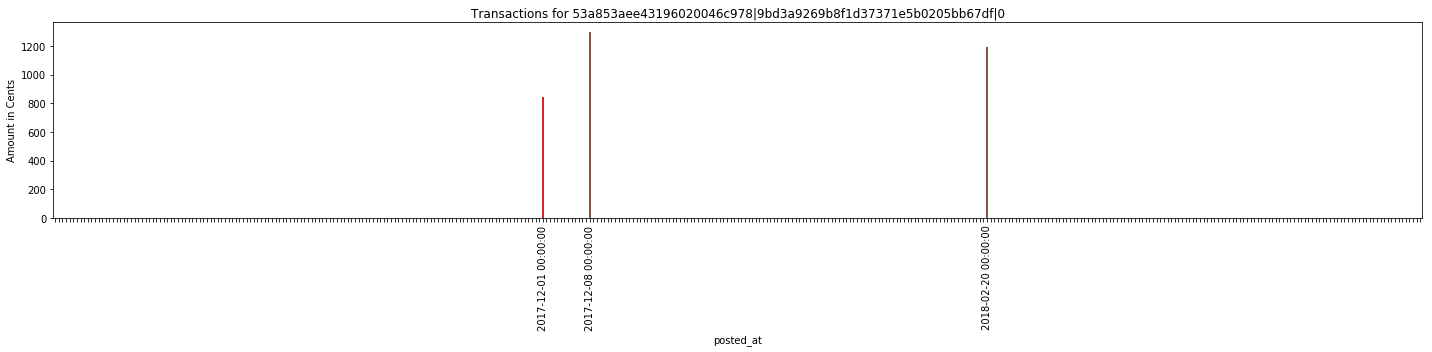

In [360]:
plot_individual('53a853aee43196020046c978|9bd3a9269b8f1d37371e5b0205bb67df|0', series)
# plot_individual('54b4106019e5e80b008ddf1d|6d4a5bea1d14c3165a6251e2279af962|0', series)

In [ ]:
'53a85331e431960200466a39|140fae5cfea3485ab5c6d7f7266677ba|0'

In [154]:
for sample in all_data_sequences[:10]:
    s_id = sample[0]
    seq = sample[1:]
    

[['53a85331e431960200466a39|140fae5cfea3485ab5c6d7f7266677ba|0', 37, 14],
 ['53a85378e431960200469d42|76f7222aa18d6b39a7ebdd5168b1ffd4|0'],
 ['53a85378e431960200469d42|ff242a09ec5b7f16a4941334c39783ea|0',
  1,
  1,
  1,
  1,
  4,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  4,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  2,
  3,
  1,
  1,
  1,
  1,
  3,
  2,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  5,
  1,
  1,
  1,
  4,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  4,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  4,
  1,
  2,
  3,
  1,
  1,
  1,
  1,
  4,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  4,


Series Id with multiple linked accounts

In [145]:
account_posted_at_group = dat.sort_values('posted_at').groupby(['account_id', 'posted_at']).count()
print(account_posted_at_group['amount_cents'].value_counts())
unique_accounts = account_posted_at_group[account_posted_at_group['amount_cents'] == 1]
non_unique_accounts = account_posted_at_group[account_posted_at_group['amount_cents'] > 1]
print()
print('unique accounts: {}'.format(len(unique_accounts)))
print('non unique accounts: {}'.format(len(non_unique_accounts)))

1    369232
2      2620
3        12
Name: amount_cents, dtype: int64

unique accounts: 369232
non unique accounts: 2632


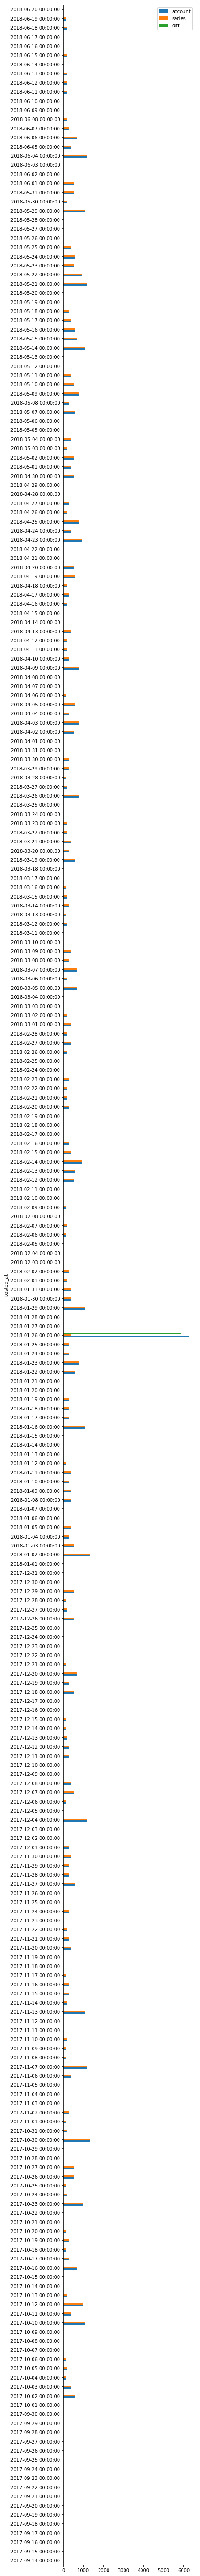

In [146]:
fig, ax = plt.subplots()
joined = pd.DataFrame(accounts.loc['53a85378e431960200469d42']).join(pd.DataFrame(series.loc['53a85378e431960200469d42|ff242a09ec5b7f16a4941334c39783ea|0']))
joined.columns = ['account', 'series']
joined['diff'] = joined['account'] - joined['series']
joined.plot(kind='barh', figsize=(5, 100), ax=ax)
for label, value in zip(ax.yaxis.get_ticklabels(), joined.account):
    if value <= 0:
        label.set_visible(False)

In [150]:
with_series_dat = dat.copy()
with_series_dat['series_account_id'] = with_series_dat.series_id.map(lambda x: x.split('|')[0])
with_series_dat.head()

In [149]:
# with_series_dat[with_series_dat['series_account_id'] == '53a85378e431960200469d42'].groupby(
#             ['series_id', 'posted_at']).mean().head()

In [148]:
# series_id with account_id

# fig, ax = plt.subplots()
# joined = pd.DataFrame(accounts.loc['53a85378e431960200469d42']).join(pd.DataFrame(series.loc['53a85378e431960200469d42|ff242a09ec5b7f16a4941334c39783ea|0']))
# joined.columns = ['account', 'series']
# joined['diff'] = joined['account'] - joined['series']
# joined.plot(kind='barh', figsize=(5, 100), ax=ax)
# for label, value in zip(ax.yaxis.get_ticklabels(), joined.account):
#     if value <= 0:
#         label.set_visible(False)

In [7]:
# bad way
# def individual_account(account, dat):
#     sample_account = dat[dat.account_id == account].sort_values('posted_at')[['posted_at','amount_cents']].set_index('posted_at')
#     idx = pd.date_range(dat.posted_at.min(), dat.posted_at.max())
#     sample_account.index = pd.DatetimeIndex(sample_account.index)
#     sample_account = sample_account.reindex(idx, fill_value=0)
#     sample_time_series = pd.DataFrame(sample_account.unstack(level=-1)).fillna(False)
#     sample_time_series.columns = ['amount_cents']
#     return sample_time_series

# sample = individual_account('54b80cb0cb084b0c00294f2a', dat)
# sample.plot(kind='bar', figsize=(20, 5))
# sample
# plt.xticks(np.where(sample.amount_cents != 0)[0])
# plt.tight_layout()


In [113]:
series.fillna(0).head()

posted_at,2017-09-14 00:00:00,2017-09-15 00:00:00,2017-09-16 00:00:00,2017-09-17 00:00:00,2017-09-18 00:00:00,2017-09-19 00:00:00,2017-09-20 00:00:00,2017-09-21 00:00:00,2017-09-22 00:00:00,2017-09-23 00:00:00,...,2018-06-11 00:00:00,2018-06-12 00:00:00,2018-06-13 00:00:00,2018-06-14 00:00:00,2018-06-15 00:00:00,2018-06-16 00:00:00,2018-06-17 00:00:00,2018-06-18 00:00:00,2018-06-19 00:00:00,2018-06-20 00:00:00
series_id,,,,,,,,,,,,,,,,,,,,,
53a85331e431960200466a39|140fae5cfea3485ab5c6d7f7266677ba|0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53a85378e431960200469d42|76f7222aa18d6b39a7ebdd5168b1ffd4|0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53a85378e431960200469d42|ff242a09ec5b7f16a4941334c39783ea|0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,200.0,200.0,200.0,0.0,200.0,0.0,0.0,200.0,100.0,0.0
53a85392e43196020046b36b|76d3583b46575283f21d8cd598659d4c|0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53a853aee43196020046c978|9bd3a9269b8f1d37371e5b0205bb67df|0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
# from a time (dt) go back (minus) day to get data from days a certain number of days (periods)
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

In [131]:
def prepare_dataset(df, t2017, is_train=True, name_prefix=None):

    X = {}
#     for i in [3, 7, 14, 30, 60, 140]:
#         tmp1 = get_timespan(df, t2017, i, i)
#         tmp2 = (get_timespan(promo_df, t2017, i, i) > 0) * 1
        # mean encoding based on promo
#         X['has_promo_mean_%s' % i] = (tmp1 * tmp2.replace(0, np.nan)).mean(axis=1).values
        # weighted moving average
#         X['has_promo_mean_%s_decay' % i] = (tmp1 * tmp2.replace(0, np.nan) * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
#         X['no_promo_mean_%s' % i] = (tmp1 * (1 - tmp2).replace(0, np.nan)).mean(axis=1).values
#         X['no_promo_mean_%s_decay' % i] = (tmp1 * (1 - tmp2).replace(0, np.nan) * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
    
#     for i in [3, 7, 14, 30, 60, 140]:
    for i in [3, 7, 14, 30]:
        # difference in previous days 
        tmp = get_timespan(df, t2017, i, i)
        X['diff_%s_mean' % i] = tmp.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        X['mean_%s' % i] = tmp.mean(axis=1).values
        X['median_%s' % i] = tmp.median(axis=1).values
        X['min_%s' % i] = tmp.min(axis=1).values
        X['max_%s' % i] = tmp.max(axis=1).values
        X['std_%s' % i] = tmp.std(axis=1).values
    
#     for i in [3, 7, 14, 30, 60, 140]:
    for i in [3, 7, 14, 30]:
        # difference in previous days (week before)
        tmp = get_timespan(df, t2017 + timedelta(days=-7), i, i)
        X['diff_%s_mean_2' % i] = tmp.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay_2' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        X['mean_%s_2' % i] = tmp.mean(axis=1).values
        X['median_%s_2' % i] = tmp.median(axis=1).values
        X['min_%s_2' % i] = tmp.min(axis=1).values
        X['max_%s_2' % i] = tmp.max(axis=1).values
        X['std_%s_2' % i] = tmp.std(axis=1).values
        
#     for i in [7, 14, 30, 60, 140]:
    for i in [3, 7, 14, 30]:
        # days since last appearance
        tmp = get_timespan(df, t2017, i, i)
        # sum of sales in the last i days 
        X['has_sales_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
        # max of sales for last i days (ordering)
        X['last_has_sales_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
        X['first_has_sales_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values
#         # same with promo
#         tmp = get_timespan(promo_df, t2017, i, i)
#         X['has_promo_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
#         X['last_has_promo_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
#         X['first_has_promo_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values
        
    # 15 days only 
#     tmp = get_timespan(promo_df, t2017 + timedelta(days=16), 15, 15)
#     X['has_promo_days_in_after_15_days'] = (tmp > 0).sum(axis=1).values
#     X['last_has_promo_day_in_after_15_days'] = i - ((tmp > 0) * np.arange(15)).max(axis=1).values
#     X['first_has_promo_day_in_after_15_days'] = ((tmp > 0) * np.arange(15, 0, -1)).max(axis=1).values

    for i in range(1, 16):
        # get sales for previous days 
        X['day_%s_2017' % i] = get_timespan(df, t2017, i, 1).values.ravel()
        
    for i in range(7):
        # get mean of day of week sales (ex: means sales for Monday)
        X['mean_4_dow{}_2017'.format(i)] = get_timespan(df, t2017, 28-i, 4, freq='7D').mean(axis=1).values
#         X['mean_20_dow{}_2017'.format(i)] = get_timespan(df, t2017, 140-i, 20, freq='7D').mean(axis=1).values
        X['mean_7_dow{}_2017'.format(i)] = get_timespan(df, t2017, 7-i, 7, freq='7D').mean(axis=1).values

#     for i in range(-16, 16):
#         # get promo for 16 before and 16 after
#         X["promo_{}".format(i)] = promo_df[t2017 + timedelta(days=i)].values.astype(np.uint8)

    # to pandas DF
    X = pd.DataFrame(X)
    
    if is_train:
        y = df[pd.date_range(t2017, periods=16)].values
        return X, y
    if name_prefix is not None:
        X.columns = ['%s_%s' % (name_prefix, c) for c in X.columns]
    return X

In [129]:
series.columns

DatetimeIndex(['2017-09-14', '2017-09-15', '2017-09-16', '2017-09-17',
               '2017-09-18', '2017-09-19', '2017-09-20', '2017-09-21',
               '2017-09-22', '2017-09-23',
               ...
               '2018-06-11', '2018-06-12', '2018-06-13', '2018-06-14',
               '2018-06-15', '2018-06-16', '2018-06-17', '2018-06-18',
               '2018-06-19', '2018-06-20'],
              dtype='datetime64[ns]', name='posted_at', length=280, freq=None)

In [133]:
t2017 = date(2018, 1, 1) #+ timedelta(days=30)
num_days = 6
X_l, y_l = [], []

for i in range(num_days):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(series, t2017 + delta)

In [139]:
import lightgbm as lgb

params = {
    'num_leaves': 80,
    'objective': 'regression',
    'min_data_in_leaf': 200,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 16,
    'device': 'gpu'
}

MAX_ROUNDS = 5000
cate_vars = []

dtrain = lgb.Dataset(
        X_tmp, label=y_tmp[:, 1],
        categorical_feature=cate_vars
    )
# dval = lgb.Dataset(
#         X_val, label=y_val[:, 1], reference=dtrain,
#         weight=items["perishable"] * 0.25 + 1,
#         categorical_feature=cate_vars)

    
bst = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS, 
                valid_sets=[dtrain], early_stopping_rounds=125, verbose_eval=50)

/home/matt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 125 rounds.
[50]	training's l2: nan
[100]	training's l2: nan


TypeError: 'NoneType' object is not iterable

In [ ]:
%%time
t2017 = date(2017, 6, 14)
num_days = 6
X_l, y_l = [], []

for i in range(num_days):
    delta = timedelta(days=7 * i)
    # train dataset
    X_tmp, y_tmp = prepare_dataset(df_2017, promo_2017, t2017 + delta)
    # item dataset
    X_tmp2 = prepare_dataset(df_2017_items, promo_2017_item, t2017 + delta, is_train=False, name_prefix='item')
    X_tmp2.index = df_2017_items.index
    X_tmp2 = X_tmp2.reindex(df_2017.index.get_level_values(1)).reset_index(drop=True)
    # store class dataset 
    X_tmp3 = prepare_dataset(df_2017_store_class, df_2017_promo_store_class, t2017 + delta, is_train=False, name_prefix='store_class')
    X_tmp3.index = df_2017_store_class.index
    X_tmp3 = X_tmp3.reindex(df_2017_store_class_index).reset_index(drop=True)
    # concat all datasets 
    X_tmp = pd.concat([X_tmp, X_tmp2, X_tmp3, items.reset_index(), stores.reset_index()], axis=1)
    # append to arrays
    X_l.append(X_tmp)
    y_l.append(y_tmp)

    del X_tmp2
    gc.collect()
    
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)

del X_l, y_l